**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Bidirectional, Dense, Dropout , Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

**Read Dataset**

In [2]:
df = pd.read_csv("fake-news-classification/WELFake_Dataset.csv")
df.shape

(72134, 4)

In [3]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
df.drop("Unnamed: 0" , axis = 1, inplace = True)

**Check if data has Null values**

In [5]:
df.isna().sum()

title    558
text      39
label      0
dtype: int64

**Drop null values**

In [6]:
df.dropna(inplace = True)
print("data after removing null values : ", df.shape)

data after removing null values :  (71537, 3)


**check if data has duplicated values**

In [7]:
df.duplicated().sum()

np.int64(8416)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71537 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71537 non-null  object
 1   text    71537 non-null  object
 2   label   71537 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [9]:
df.head(3)

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0


In [10]:
df.reset_index(inplace = True)
df.drop("index" ,axis=1 ,inplace = True)
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


**Split data to features & label**

In [11]:
X = df.drop("label" , axis =1)
y = df["label"]

print("Features : " , X.shape)
print("target(Label) : " , y.shape)

Features :  (71537, 2)
target(Label) :  (71537,)


*Take a copy of features*

In [12]:
messages = X.copy()
print(messages.shape)

(71537, 2)


In [13]:
messages.head()

,title,text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...


*reset the index after remove nulls*

In [14]:
messages["title"][1]

'UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO]'

**Text Preprocessing**

In [15]:
# nltk.download("wordnet")
# nltk.download("stopwords")

In [16]:
lemmatizer = WordNetLemmatizer()

corpus = []

for i in range(0,len(messages)):
    review = re.sub("[^a-zA-Z]" , " ", messages["title"][i])
    review = review.lower()
    review = word_tokenize(review)
    review = [lemmatizer.lemmatize(word) for word in review if word not in stopwords.words("english")]
    review = " ".join(review)
    corpus.append(review)

print(corpus[0])

law enforcement high alert following threat cop white blacklivesmatter fyf terrorist video


In [17]:
# Vocabulary_Size
voc_size = 5000

In [18]:
tokenizer = Tokenizer(num_words=voc_size , oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)

In [19]:
sequences[0]

[72, 1729, 279, 1171, 1389, 180, 124, 17, 1652, 1, 148, 3]

In [20]:
corpus[0]

'law enforcement high alert following threat cop white blacklivesmatter fyf terrorist video'

In [21]:
max_length = 0
for i in sequences:
    if len(i) > max_length:
        max_length = len(i)

print(max_length)

47


In [22]:
embedded_docs = pad_sequences(sequences , padding = "post" , maxlen = max_length)
print(embedded_docs[0])

[  72 1729  279 1171 1389  180  124   17 1652    1  148    3    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


In [23]:
X_final = np.array(embedded_docs)
y_final  = np.array(y)

print("feature_shape :" , X_final.shape)
print("label_shape :" , y_final.shape)

feature_shape : (71537, 47)
label_shape : (71537,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.2 , shuffle=True, random_state=42)
print(X_train.shape , X_test.shape, y_train.shape,y_test.shape)

(57229, 47) (14308, 47) (57229,) (14308,)


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size = 0.15 , shuffle = True, random_state=42)
print(X_train.shape, X_val.shape , y_train.shape, y_val.shape)

(48644, 47) (8585, 47) (48644,) (8585,)


In [26]:
print("shape of features to Training : ", X_train.shape)
print("shape of features to Validation : ", X_val.shape)
print("shape of features to Testing : ", X_test.shape)
print("shape of Label/target to Training : ", y_train.shape)
print("shape of Label/target to Validation : ", y_val.shape)
print("shape of Label/target to Testing : ", y_test.shape)


shape of features to Training :  (48644, 47)
shape of features to Validation :  (8585, 47)
shape of features to Testing :  (14308, 47)
shape of Label/target to Training :  (48644,)
shape of Label/target to Validation :  (8585,)
shape of Label/target to Testing :  (14308,)


In [27]:
embededding_vector_features = 40

model = Sequential([
    Embedding(input_dim=voc_size ,output_dim=embededding_vector_features ,  input_shape=(max_length,)),
    Bidirectional(LSTM(units=200)),
    Dropout(0.3),
    Dense(1,activation = "sigmoid")
])

model.compile(optimizer = "adam" , 
              loss = "binary_crossentropy" , 
              metrics = ["accuracy"])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 47, 40)         │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 400)            │       385,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,001 (2.24 MB)

 Trainable params: 586,001 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
early_stopping = EarlyStopping(patience=3 , restore_best_weights = True)
checkpoint =  ModelCheckpoint("FakeNewsBi-LSTM.keras" , save_best_only=True)

In [30]:
history = model.fit(X_train,y_train , epochs=20 , batch_size=128 , 
                    validation_data=(X_val,y_val) , callbacks=[early_stopping, checkpoint])

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 61s 146ms/step - accuracy: 0.7293 - loss: 0.5379 - val_accuracy: 0.8487 - val_loss: 0.3409
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 52s 137ms/step - accuracy: 0.9064 - loss: 0.2334 - val_accuracy: 0.9081 - val_loss: 0.2240
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - accuracy: 0.9319 - loss: 0.1772 - val_accuracy: 0.9020 - val_loss: 0.2534
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - accuracy: 0.9402 - loss: 0.1532 - val_accuracy: 0.9054 - val_loss: 0.2418
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9474 - loss: 0.1370 - val_accuracy: 0.9041 - val_loss: 0.2573


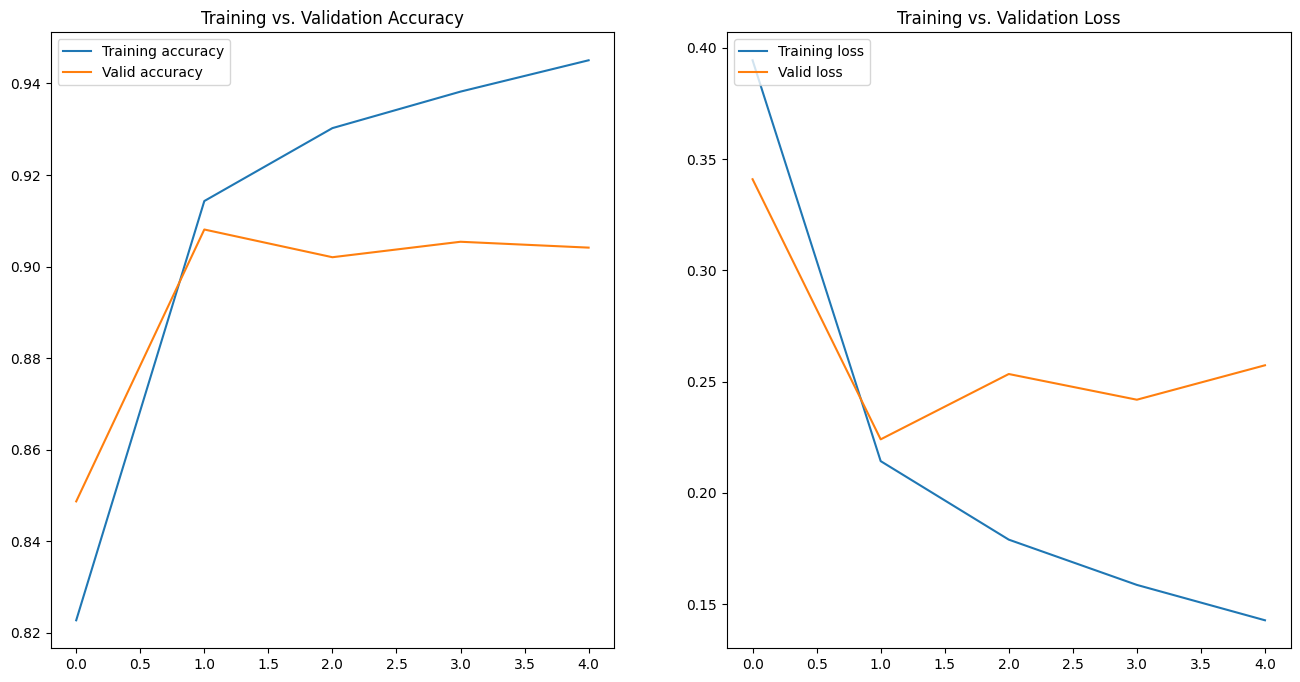

In [39]:
loss = history.history["loss"]
accuracy = history.history['accuracy']
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs_range = range(len(accuracy))

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(epochs_range , accuracy , label = "Training accuracy")
plt.plot(epochs_range, val_accuracy , label = "Valid accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend(loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs_range , loss , label="Training loss")
plt.plot(epochs_range, val_loss, label="Valid loss")
plt.title("Training vs. Validation Loss")
plt.legend(loc = "upper left")

plt.show()

In [40]:
loss , accuracy = model.evaluate(X_test,y_test)
print(f"Test loss : {loss:.4f}")
print(f"Test accuracy : {accuracy*100:.2f}%")

448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9068 - loss: 0.2276
Test loss : 0.2241
Test accuracy : 91.00%


In [41]:
y_prop = model.predict(X_test)
y_prop[0]

448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step


array([0.4162556], dtype=float32)

In [42]:
y_pred = np.where(y_prop >0.5 , 1,0)
print(y_pred[:10])

[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]]


In [43]:
print(y_test[:10])

[1 0 0 1 0 1 1 0 1 1]


In [44]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[6287,  794],
       [ 494, 6733]])

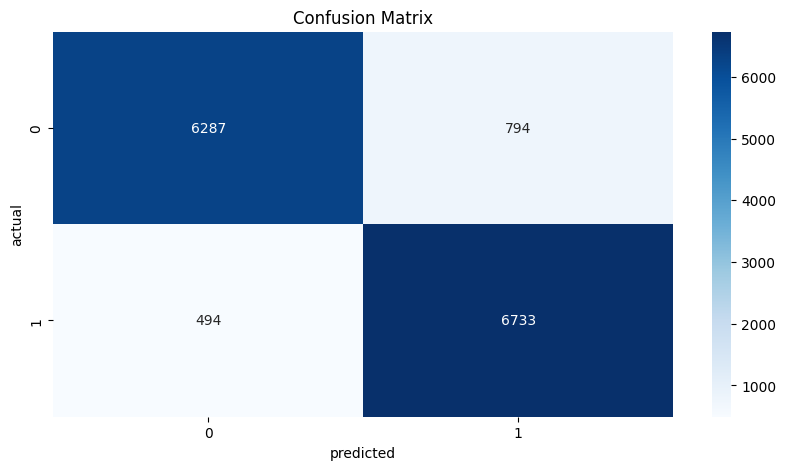

In [45]:
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True , cmap="Blues" , fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

In [46]:
print("💠 Classification Report :")
print(classification_report(y_test, y_pred))

💠 Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      7081
           1       0.89      0.93      0.91      7227

    accuracy                           0.91     14308
   macro avg       0.91      0.91      0.91     14308
weighted avg       0.91      0.91      0.91     14308

